<a href="https://colab.research.google.com/github/KyungRyeolBaek/study/blob/main/AI%20study/%EC%B9%98%EC%95%84/tooth_CNN_210804.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# tooth_CNN

In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib 
device_lib.list_local_devices() 
tf.test.is_gpu_available()
# cmd와 jupyter notebook cell에서 모두 True값이 나와야 함

True

In [ ]:
# parameter
image_num = [0, 1, 2, 3, 4, 5, 6, 7, 8]       # 전체 이미지
train_image_num = [1, 2, 3, 4, 5, 6, 7, 8]    # 트레이닝 이미지 범위 [1, 2, 3, 4, 5, 6, 7, 8]
test_image_num = 0                            # 테스트 이미지 숫자 [0]
X_shape = [3+3, 6]                              # X 형태 [행, 열] -> 트레이닝 크기
y_shape = 5                                   # y 형태 -> 트레이닝 결과 크기
y_test_range = [120, 125]                     # y_test 예측 범위 [120 ~ 125]
epoch = 1000                                  # epoch 횟수


def tooth_CNN(image_num = image_num, train_image_num = train_image_num, test_image_num = test_image_num, X_shape = X_shape, y_shape = y_shape, y_test_range = y_test_range, epoch = epoch):
    import tensorflow as tf
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    import math
    from tensorflow.keras import datasets, layers, models

    for num in image_num: 
        globals()['df{}'.format(num)] = pd.read_table('./images/sino_examples/sino_{}.txt'.format(num),sep=',', header = None)
        globals()['df{}'.format(num)] = globals()['df{}'.format(num)] / math.ceil(globals()['df{}'.format(num)].max().max())

    # train셋, test셋으로 나누어 줍니다. X는 입력 변수, y는 출력 변수
    X_train_org, X_test_org, y_train_org, y_test_org = [], [], [], []

    # X 형태 (3+3, 6), y 형태 (5)
    for num in train_image_num:
        for i in range(360 - X_shape[1]):                             # i, 열, 1
            for j in range(256 - X_shape[0] - y_shape):                # j, 행, 0
                X_train_org.append(pd.concat([globals()['df{}'.format(num)].iloc[j:j+int(X_shape[0]/2), 0+i:X_shape[1]+i], globals()['df{}'.format(num)].iloc[j+int(X_shape[0]/2)+y_shape:j+int(X_shape[0]/2)+y_shape+int(X_shape[0]/2), 0+i:X_shape[1]+i]], axis = 0))           # 아래
                if X_shape[1] % 2 == 0:
                    y_train_org.append(globals()['df{}'.format(num)].iloc[j+int(X_shape[0]/2):j+int(X_shape[0]/2)+y_shape, i+int(X_shape[1]/2)])
                else:
                    y_train_org.append(globals()['df{}'.format(num)].iloc[j+int(X_shape[0]/2):j+int(X_shape[0]/2)+y_shape, i+int(X_shape[1]/2)+1])

    for i in range(360 - X_shape[1]):
        X_test_org.append(pd.concat([globals()['df{}'.format(test_image_num)].iloc[y_test_range[0] - int(X_shape[0]/2):y_test_range[0], 0+i:X_shape[1]+i], globals()['df{}'.format(test_image_num)].iloc[y_test_range[1]:y_test_range[1] + int(X_shape[0]/2), 0+i:X_shape[1]+i]], axis = 0))
        if X_shape[1] % 2 == 0:
            y_test_org.append(globals()['df{}'.format(test_image_num)].iloc[y_test_range[0]:y_test_range[1], i+int(X_shape[1]/2)])
        else:
            y_test_org.append(globals()['df{}'.format(test_image_num)].iloc[y_test_range[0]:y_test_range[1], i+int(X_shape[1]/2)+1])
            
    X_train_org, X_test_org, y_train_org, y_test_org = np.array(X_train_org), np.array(X_test_org), np.array(y_train_org), np.array(y_test_org)

    # RGB 값을 추가 합니다. 우선 흑백으로 설정 하였습니다.
    # train 형태 : ((8*354*245, 6, 6, 1)), test 형태 : ((354, 6, 6, 1))
    # tensorflow는 3차원만 지원하므로 3차원 형태로 reshape 해줘야 합니다.
    X_train = X_train_org.reshape((len(train_image_num)*(360-X_shape[1])*(256-X_shape[0]-y_shape), X_shape[0], X_shape[1], 1))
    X_test = X_test_org.reshape(((360-X_shape[1]), X_shape[0], X_shape[1], 1))
    y_train = y_train_org
    y_test = y_test_org

    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X_shape[0], X_shape[1], 1)))
    # MaxPooling2D(filter)
    # model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    # model.add(layers.MaxPooling2D((2, 2)))
    # model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(5))
    model.summary()

    # model 구성
    model.compile(optimizer='adam',
                loss='mse',
                metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=epoch, verbose = 0)

    test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)      # test 데이터를 넣었을 때의 loss, acc
    print(test_acc)   # 정확도

    # 모델 예측
    pred = model.predict(X_test)    # 예측 데이터를 ()안에 넣으면 됩니다.

    figure, axes = plt.subplots(nrows=2, ncols=2, figsize = (35, 15))
    axes[0][0].set_title('Test Image')
    axes[0][0].imshow(y_test_org.T)
    axes[0][1].set_title('Pred Image')
    axes[0][1].imshow(pred.T)
    axes[1][0].set_title('Test Image')
    axes[1][0].imshow(globals()['df{}'.format(test_image_num)])
    df_test_img = globals()['df{}'.format(test_image_num)]
    df_test_img.iloc[y_test_range[0]:y_test_range[1], 0+int(X_shape[1]/2):360-int(X_shape[1]/2)] = pred.T
    axes[1][1].set_title('Pred Image')
    axes[1][1].imshow(df_test_img)
    figure.colorbar;

    figure.tight_layout()
    plt.show()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 4, 4, 32)          320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 2, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 35,589
Trainable params: 35,589
Non-trainable params: 0
_________________________________________________________________
12/12 - 0s - loss: 1.7782e-04 - accuracy: 0.5537
0.5536723136901855


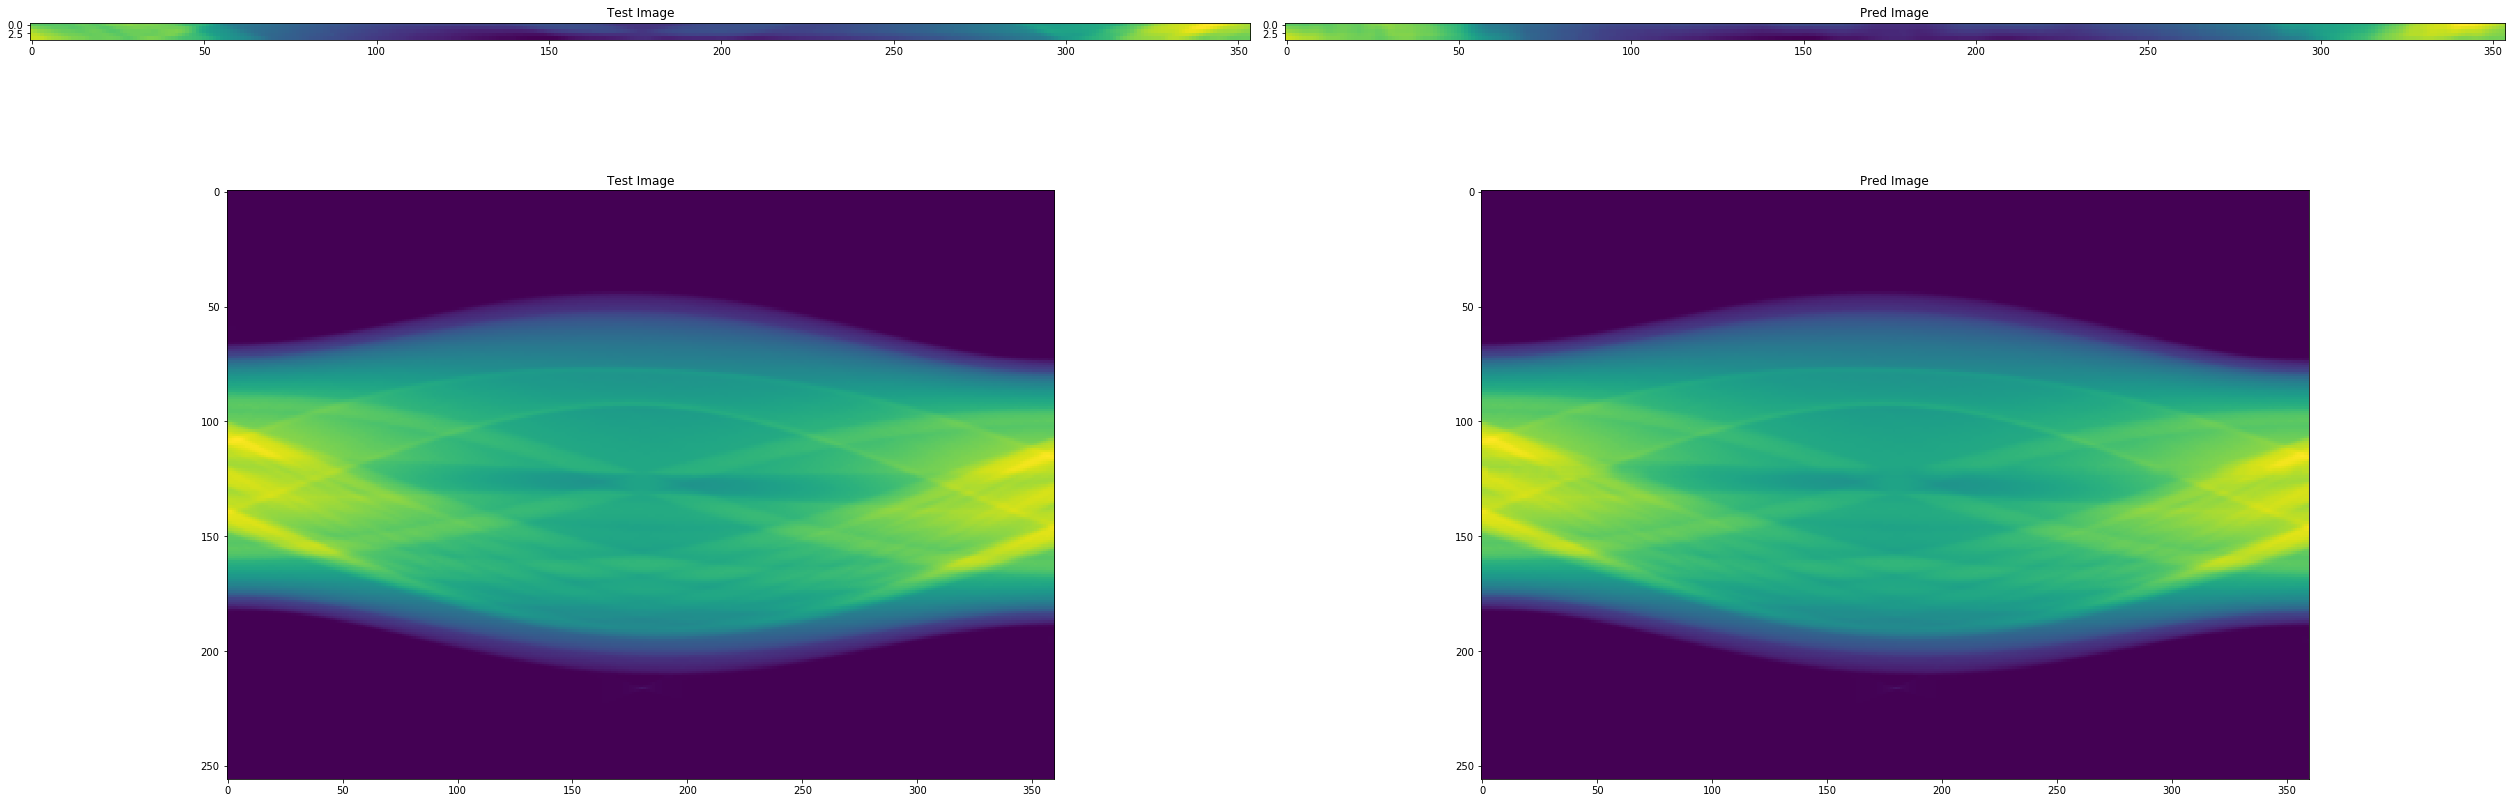

In [ ]:
# parameter
image_num = [0, 1, 2, 3, 4, 5, 6, 7, 8]       # 전체 이미지
train_image_num = [1, 2, 3, 4, 5, 6, 7, 8]    # 트레이닝 이미지 범위 [1, 2, 3, 4, 5, 6, 7, 8]
test_image_num = 0                            # 테스트 이미지 숫자 [0]
X_shape = [6, 6]                            # X 형태 [행, 열] -> 트레이닝 크기
y_shape = 5                                   # y 형태 -> 트레이닝 결과 크기
y_test_range = [120, 125]                     # y_test 예측 범위 [120 ~ 125]
epoch = 1000                                  # epoch 횟수

tooth_CNN(image_num = image_num, train_image_num = train_image_num, test_image_num = test_image_num, X_shape = X_shape, y_shape = y_shape, y_test_range = y_test_range, epoch = epoch)

In [ ]:
import tensorflow as tf
# Ture가 나와야 GPU가 작동 되는 중 !
from tensorflow.python.client import device_lib 
device_lib.list_local_devices() 
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

생각해보니 def 안에 넣어 놓으면 안의 변수를 가져올수가 없어서..

아래 코드처럼 def 밖으로 빼는게 좋아 보여요 !

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 18, 19, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 17, 64)        18496     
_________________________________________________________________
flatten (Flatten)            (None, 17408)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1114176   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 1,133,317
Trainable params: 1,133,317
Non-trainable params: 0
_________________________________________________________________
11/11 - 0s - loss: 1.2330e-04 - accuracy: 0.5457
0.5457227230072021


ValueError: could not broadcast input array from shape (5,339) into shape (5,340)

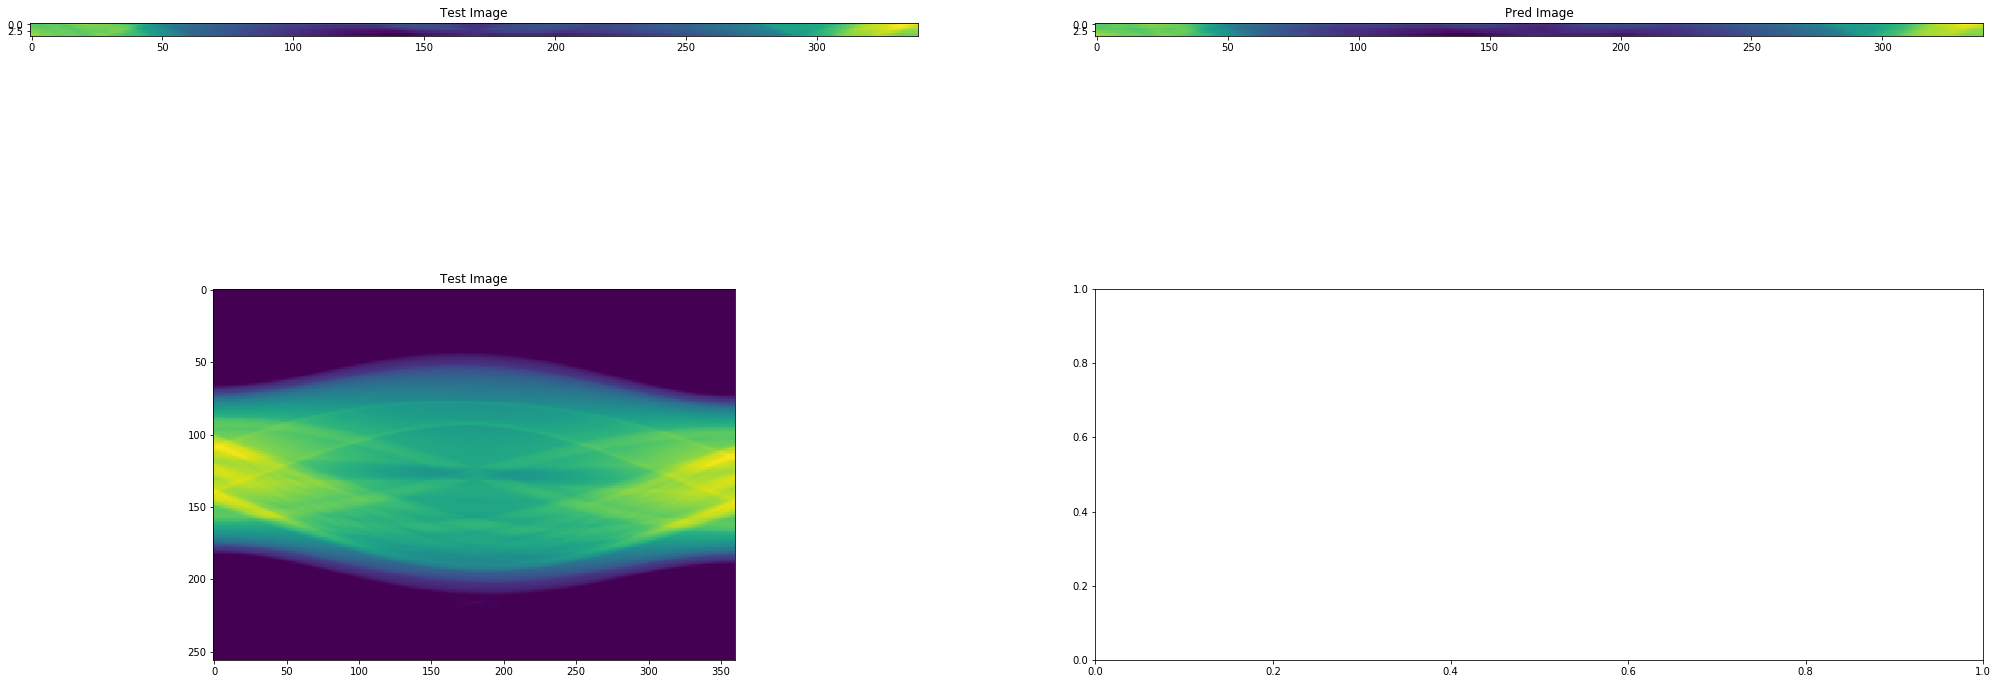

In [ ]:
# parameter
image_num = [0, 1, 2, 3, 4, 5, 6, 7, 8]       # 전체 이미지
train_image_num = [1, 2, 3, 4, 5, 6, 7, 8]    # 트레이닝 이미지 범위 [1, 2, 3, 4, 5, 6, 7, 8]
test_image_num = 0                            # 테스트 이미지 숫자 [0]
X_shape = [20, 21]                            # X 형태 [행, 열] -> 트레이닝 크기
y_shape = 5                                   # y 형태 -> 트레이닝 결과 크기
y_test_range = [120, 125]                     # y_test 예측 범위 [120 ~ 125]
epoch = 1000                                  # epoch 횟수

import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from tensorflow.keras import datasets, layers, models

for num in image_num: 
    globals()['df{}'.format(num)] = pd.read_table('./images/sino_examples/sino_{}.txt'.format(num),sep=',', header = None)
    globals()['df{}'.format(num)] = globals()['df{}'.format(num)] / math.ceil(globals()['df{}'.format(num)].max().max())

# train셋, test셋으로 나누어 줍니다. X는 입력 변수, y는 출력 변수
X_train_org, X_test_org, y_train_org, y_test_org = [], [], [], []

# X 형태 (3+3, 6), y 형태 (5)
for num in train_image_num:
    for i in range(360 - X_shape[1]):                             # i, 열, 1
        for j in range(256 - X_shape[0] - y_shape):                # j, 행, 0
            X_train_org.append(pd.concat([globals()['df{}'.format(num)].iloc[j:j+int(X_shape[0]/2), 0+i:X_shape[1]+i], globals()['df{}'.format(num)].iloc[j+int(X_shape[0]/2)+y_shape:j+int(X_shape[0]/2)+y_shape+int(X_shape[0]/2), 0+i:X_shape[1]+i]], axis = 0))           # 아래
            if X_shape[1] % 2 == 0:
                y_train_org.append(globals()['df{}'.format(num)].iloc[j+int(X_shape[0]/2):j+int(X_shape[0]/2)+y_shape, i+int(X_shape[1]/2)])
            else:
                y_train_org.append(globals()['df{}'.format(num)].iloc[j+int(X_shape[0]/2):j+int(X_shape[0]/2)+y_shape, i+int(X_shape[1]/2)+1])

for i in range(360 - X_shape[1]):
    X_test_org.append(pd.concat([globals()['df{}'.format(test_image_num)].iloc[y_test_range[0] - int(X_shape[0]/2):y_test_range[0], 0+i:X_shape[1]+i], globals()['df{}'.format(test_image_num)].iloc[y_test_range[1]:y_test_range[1] + int(X_shape[0]/2), 0+i:X_shape[1]+i]], axis = 0))
    if X_shape[1] % 2 == 0:
        y_test_org.append(globals()['df{}'.format(test_image_num)].iloc[y_test_range[0]:y_test_range[1], i+int(X_shape[1]/2)])
    else:
        y_test_org.append(globals()['df{}'.format(test_image_num)].iloc[y_test_range[0]:y_test_range[1], i+int(X_shape[1]/2)+1])

X_train_org, X_test_org, y_train_org, y_test_org = np.array(X_train_org), np.array(X_test_org), np.array(y_train_org), np.array(y_test_org)

# RGB 값을 추가 합니다. 우선 흑백으로 설정 하였습니다.
# train 형태 : ((8*354*245, 6, 6, 1)), test 형태 : ((354, 6, 6, 1))
# tensorflow는 3차원만 지원하므로 3차원 형태로 reshape 해줘야 합니다.
X_train = X_train_org.reshape((len(train_image_num)*(360-X_shape[1])*(256-X_shape[0]-y_shape), X_shape[0], X_shape[1], 1))
X_test = X_test_org.reshape(((360-X_shape[1]), X_shape[0], X_shape[1], 1))
y_train = y_train_org
y_test = y_test_org

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X_shape[0], X_shape[1], 1)))
# MaxPooling2D(filter)
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5))
model.summary()

# model 구성
model.compile(optimizer='adam',
            loss='mse',
            metrics=['accuracy'])

model.fit(X_train, y_train, epochs=epoch, verbose = 0)

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)      # test 데이터를 넣었을 때의 loss, acc
print(test_acc)   # 정확도

# 모델 예측
pred = model.predict(X_test)    # 예측 데이터를 ()안에 넣으면 됩니다.

figure, axes = plt.subplots(nrows=2, ncols=2, figsize = (35, 15))
axes[0][0].set_title('Test Image')
axes[0][0].imshow(y_test_org.T)
axes[0][1].set_title('Pred Image')
axes[0][1].imshow(pred.T)
axes[1][0].set_title('Test Image')
axes[1][0].imshow(globals()['df{}'.format(test_image_num)])
df_test_img = globals()['df{}'.format(test_image_num)]
if X_shape[1] % 2 == 0:
    df_test_img.iloc[y_test_range[0]:y_test_range[1], 0+int(X_shape[1]/2):360-int(X_shape[1]/2)] = pred.T
else:
    df_test_img.iloc[y_test_range[0]:y_test_range[1], 0+int(X_shape[1]/2)+1:360-int(X_shape[1]/2)] = pred.T
axes[1][1].set_title('Pred Image')
axes[1][1].imshow(df_test_img)
figure.colorbar;

figure.tight_layout()
plt.show()

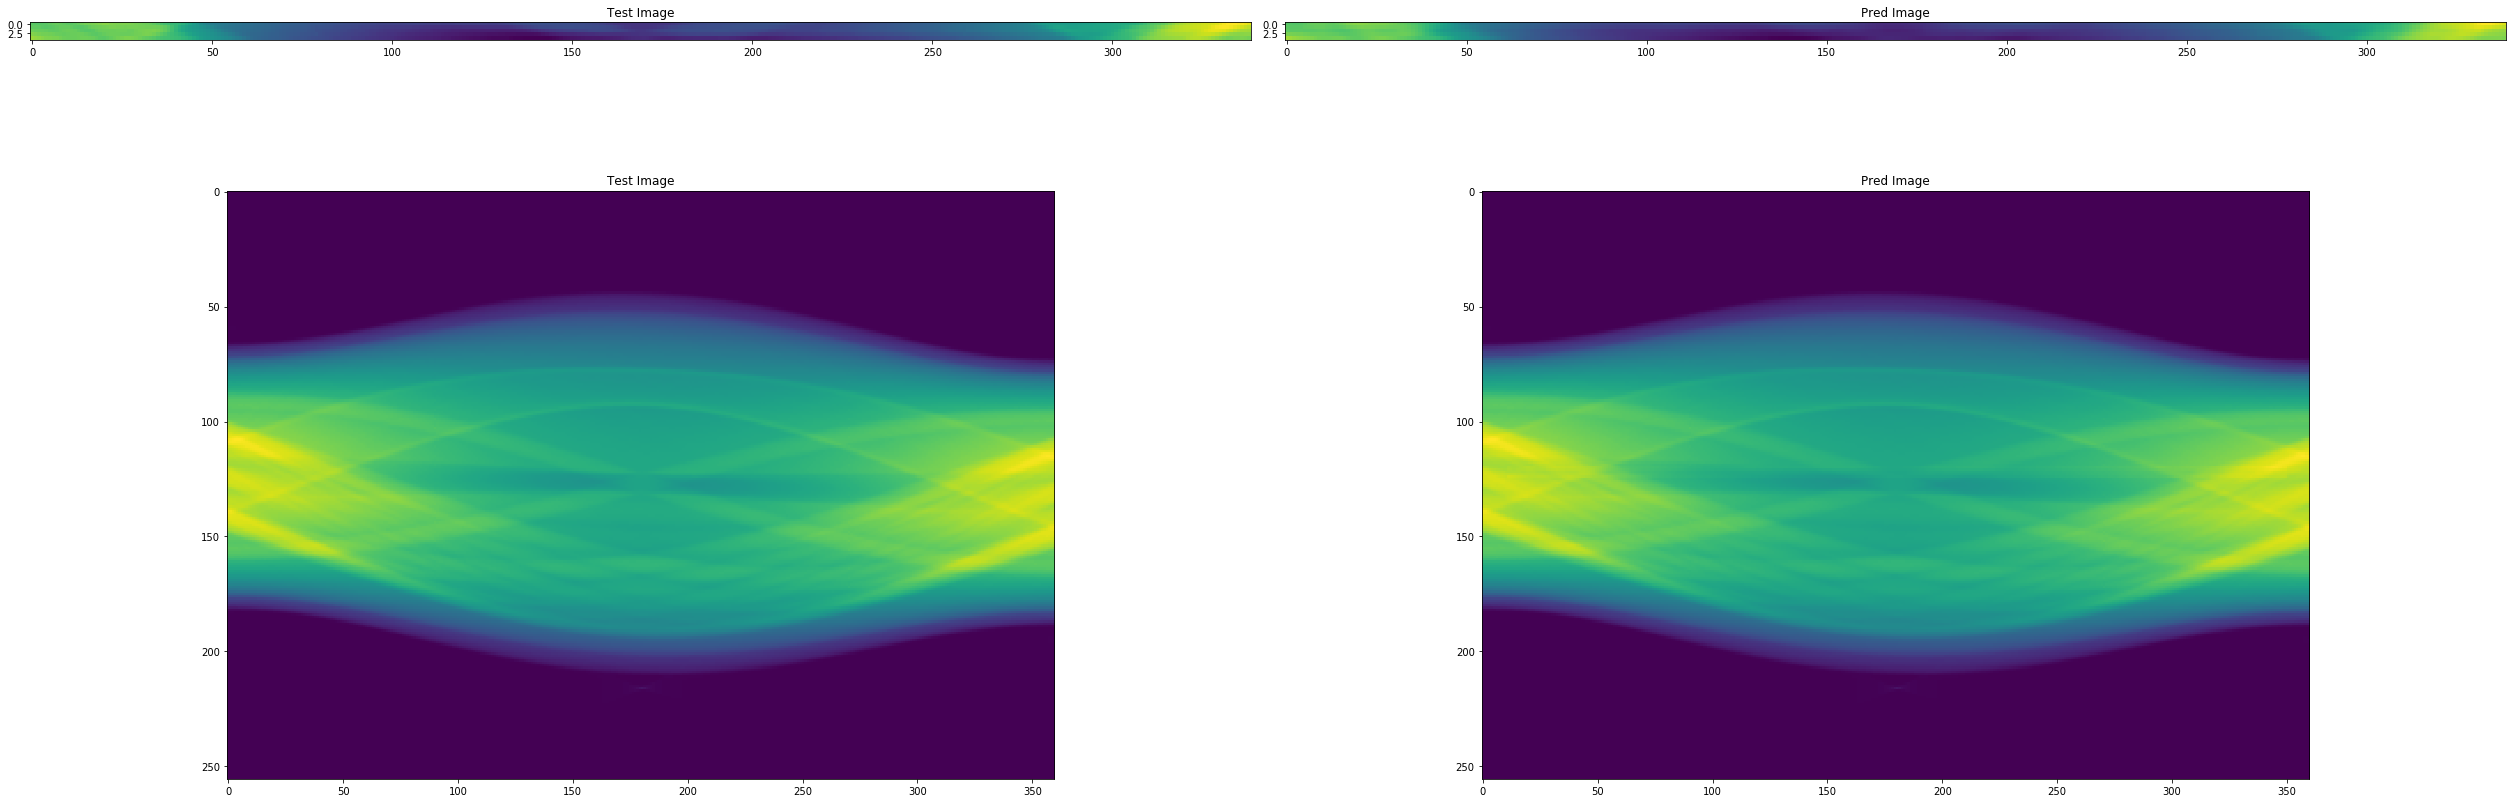

In [ ]:
# 모델 예측
pred = model.predict(X_test)    # 예측 데이터를 ()안에 넣으면 됩니다.

figure, axes = plt.subplots(nrows=2, ncols=2, figsize = (35, 15))
axes[0][0].set_title('Test Image')
axes[0][0].imshow(y_test_org.T)
axes[0][1].set_title('Pred Image')
axes[0][1].imshow(pred.T)
axes[1][0].set_title('Test Image')
axes[1][0].imshow(globals()['df{}'.format(test_image_num)])
df_test_img = globals()['df{}'.format(test_image_num)]
if X_shape[1] % 2 == 0:
    df_test_img.iloc[y_test_range[0]:y_test_range[1], 0+int(X_shape[1]/2):360-int(X_shape[1]/2)] = pred.T
else:
    df_test_img.iloc[y_test_range[0]:y_test_range[1], 0+int(X_shape[1]/2)+1:360-int(X_shape[1]/2)] = pred.T
axes[1][1].set_title('Pred Image')
axes[1][1].imshow(df_test_img)
figure.colorbar;

figure.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
# Ture가 나와야 GPU가 작동 되는 중 !
from tensorflow.python.client import device_lib 
device_lib.list_local_devices() 
tf.test.is_gpu_available()

생각해보니 def 안에 넣어 놓으면 안의 변수를 가져올수가 없어서..

아래 코드처럼 def 밖으로 빼는게 좋아 보여요 !

In [ ]:
# parameter
image_num = [0, 1, 2, 3, 4, 5, 6, 7, 8]       # 전체 이미지
train_image_num = [1, 2, 3, 4, 5, 6, 7, 8]    # 트레이닝 이미지 범위 [1, 2, 3, 4, 5, 6, 7, 8]
test_image_num = 0                            # 테스트 이미지 숫자 [0]
X_shape = [20, 21]                            # X 형태 [행, 열] -> 트레이닝 크기
y_shape = 5                                   # y 형태 -> 트레이닝 결과 크기
y_test_range = [120, 125]                     # y_test 예측 범위 [120 ~ 125]
epoch = 1000                                  # epoch 횟수

import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from tensorflow.keras import datasets, layers, models

for num in image_num: 
    globals()['df{}'.format(num)] = pd.read_table('./images/sino_examples/sino_{}.txt'.format(num),sep=',', header = None)
    globals()['df{}'.format(num)] = globals()['df{}'.format(num)] / math.ceil(globals()['df{}'.format(num)].max().max())

# train셋, test셋으로 나누어 줍니다. X는 입력 변수, y는 출력 변수
X_train_org, X_test_org, y_train_org, y_test_org = [], [], [], []

# X 형태 (3+3, 6), y 형태 (5)
for num in train_image_num:
    for i in range(360 - X_shape[1]):                             # i, 열, 1
        for j in range(256 - X_shape[0] - y_shape):                # j, 행, 0
            X_train_org.append(pd.concat([globals()['df{}'.format(num)].iloc[j:j+int(X_shape[0]/2), 0+i:X_shape[1]+i], globals()['df{}'.format(num)].iloc[j+int(X_shape[0]/2)+y_shape:j+int(X_shape[0]/2)+y_shape+int(X_shape[0]/2), 0+i:X_shape[1]+i]], axis = 0))           # 아래
            if X_shape[1] % 2 == 0:
                y_train_org.append(globals()['df{}'.format(num)].iloc[j+int(X_shape[0]/2):j+int(X_shape[0]/2)+y_shape, i+int(X_shape[1]/2)])
            else:
                y_train_org.append(globals()['df{}'.format(num)].iloc[j+int(X_shape[0]/2):j+int(X_shape[0]/2)+y_shape, i+int(X_shape[1]/2)+1])

for i in range(360 - X_shape[1]):
    X_test_org.append(pd.concat([globals()['df{}'.format(test_image_num)].iloc[y_test_range[0] - int(X_shape[0]/2):y_test_range[0], 0+i:X_shape[1]+i], globals()['df{}'.format(test_image_num)].iloc[y_test_range[1]:y_test_range[1] + int(X_shape[0]/2), 0+i:X_shape[1]+i]], axis = 0))
    if X_shape[1] % 2 == 0:
        y_test_org.append(globals()['df{}'.format(test_image_num)].iloc[y_test_range[0]:y_test_range[1], i+int(X_shape[1]/2)])
    else:
        y_test_org.append(globals()['df{}'.format(test_image_num)].iloc[y_test_range[0]:y_test_range[1], i+int(X_shape[1]/2)+1])

X_train_org, X_test_org, y_train_org, y_test_org = np.array(X_train_org), np.array(X_test_org), np.array(y_train_org), np.array(y_test_org)

# RGB 값을 추가 합니다. 우선 흑백으로 설정 하였습니다.
# train 형태 : ((8*354*245, 6, 6, 1)), test 형태 : ((354, 6, 6, 1))
# tensorflow는 3차원만 지원하므로 3차원 형태로 reshape 해줘야 합니다.
X_train = X_train_org.reshape((len(train_image_num)*(360-X_shape[1])*(256-X_shape[0]-y_shape), X_shape[0], X_shape[1], 1))
X_test = X_test_org.reshape(((360-X_shape[1]), X_shape[0], X_shape[1], 1))
y_train = y_train_org
y_test = y_test_org

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X_shape[0], X_shape[1], 1)))
# MaxPooling2D(filter)
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5))
model.summary()

# model 구성
model.compile(optimizer='adam',
            loss='mse',
            metrics=['accuracy'])

model.fit(X_train, y_train, epochs=epoch, verbose = 0)

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)      # test 데이터를 넣었을 때의 loss, acc
print(test_acc)   # 정확도

# 모델 예측
pred = model.predict(X_test)    # 예측 데이터를 ()안에 넣으면 됩니다.

figure, axes = plt.subplots(nrows=2, ncols=2, figsize = (35, 15))
axes[0][0].set_title('Test Image')
axes[0][0].imshow(y_test_org.T)
axes[0][1].set_title('Pred Image')
axes[0][1].imshow(pred.T)
axes[1][0].set_title('Test Image')
axes[1][0].imshow(globals()['df{}'.format(test_image_num)])
df_test_img = globals()['df{}'.format(test_image_num)]
if X_shape[1] % 2 == 0:
    df_test_img.iloc[y_test_range[0]:y_test_range[1], 0+int(X_shape[1]/2):360-int(X_shape[1]/2)] = pred.T
else:
    df_test_img.iloc[y_test_range[0]:y_test_range[1], 0+int(X_shape[1]/2)+1:360-int(X_shape[1]/2)] = pred.T
axes[1][1].set_title('Pred Image')
axes[1][1].imshow(df_test_img)
figure.colorbar;

figure.tight_layout()
plt.show()

In [ ]:
# mat 저장
import scipy.io as sio
# sio.savemat('df_test_img.mat', {'values' : df_test_img.values})